# Deploy pretrained VGG model on Synthetic Microscopy Images

In [36]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
from seaborn import heatmap
from sklearn.metrics import confusion_matrix
import time 

import matplotlib.pyplot as plt
from matplotlib.image import imread

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
tf.debugging.set_log_device_placement(False) 

## Defining Folders and Assiging Classes

### Reading Images from Folders and Reporting the Number of Images

Total number of classes is 13 and total number of images is  3064
the size of the image is  (1000, 1000)
the maximum value in image is  255


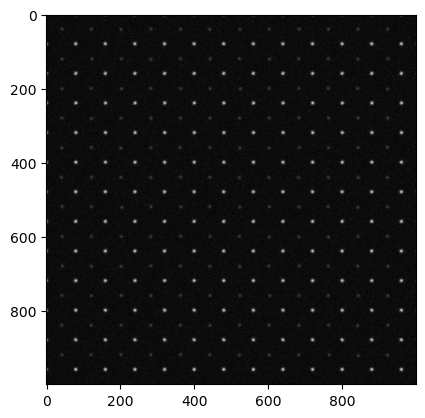

In [4]:
# The original images were classified in the folder: random-lattices
folder_path = os.path.join(os.getcwd(), "random-lattices")

# Calculate the total number of classes and images
classes = os.listdir(folder_path)

tot_number_images = 0

for each_class in classes:    
    tot_number_images += len(list(filter(lambda x: x.endswith(".png"), os.listdir(os.path.join(folder_path, each_class)))))
    
print(f"Total number of classes is {len(classes)} and total number of images is  {tot_number_images}")

# look at a random image to check
def random_image(path):
    #path=glob(train_folder+"/*/*.png")
    a=image.load_img(np.random.choice(path))
    plt.imshow(a)
    print("the size of the image is ",a.size)
    print("the maximum value in image is ",np.max(a))
    plt.show()

random_image(glob(folder_path+"/*/*.png"))

## Define some image parameters for the Model Training

In [5]:
dim1=[]
dim2=[]

for cs in os.listdir(folder_path):
    cs_path = os.path.join(folder_path, cs)
    for image_filename in os.listdir(cs_path):
        image_path = os.path.join(cs_path, image_filename)
        with Image.open(image_path) as img:    # Image.open from PIL library
            width, height = img.size
            dim1.append(width)
            dim2.append(height)
            
# We can choose the minimum image size or the average image size depends on available resources for computation
image_shape=(int(np.min(dim1)), int(np.min(dim2)))
#image_shape=(int(np.average(dim1)), int(np.average(dim2)))

image_shape

(600, 600)

**Define batch size and epochs**

In [6]:
image_size=[image_shape[0], image_shape[1]]

batch_size = 32
epochs = 15

## Image Augmentation

In [7]:
data_augmentation = Sequential([
                            layers.experimental.preprocessing.RandomRotation(factor = (0, 0.1)),
                            layers.experimental.preprocessing.Rescaling(scale = 1/255.0)
                                ])

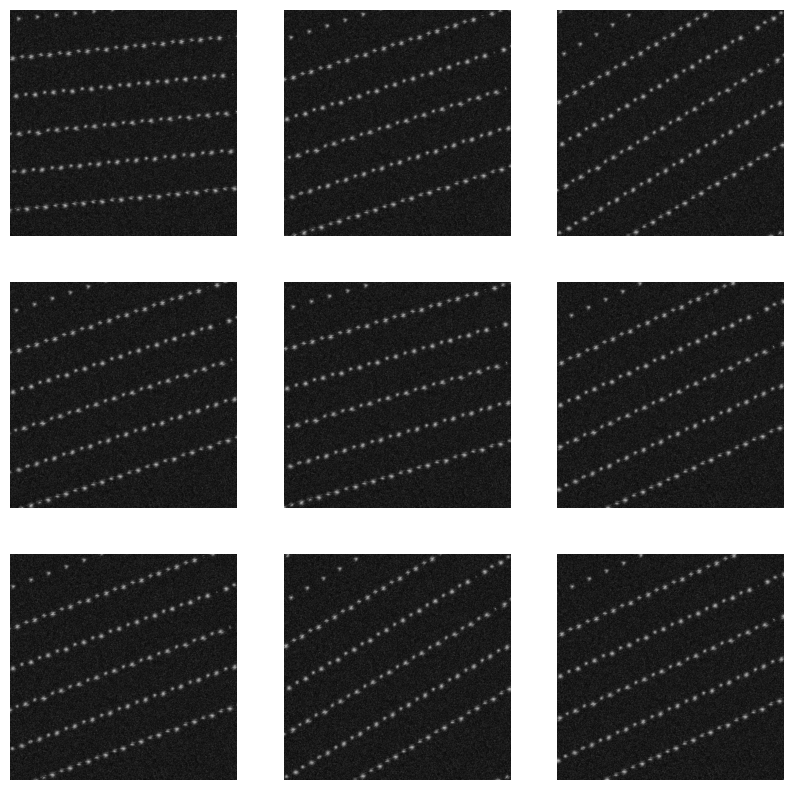

In [35]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

#Plotting a random image and apply data augmentation

#Load an image using load_image
image_random=load_img(np.random.choice(glob(folder_path+"/*/*.png")), target_size = (image_size[0], image_size[1]))

image_array = img_to_array(image_random)  

# Add the image to a batch with TensorShape([1, 600, 600, 3])
image_random = tf.cast(tf.expand_dims(image_array, 0), "float32")

plt.figure(figsize=(10,10))
for i in range(9):
    augmented_image = data_augmentation (image_random)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_image[0])
    plt.axis("off")


### Apply the preprocessing layers to your dataset

In [9]:
# it yields `float32` tensors of shape `(batch_size, image_size[0], image_size[1], num_channels)`
ds_train = image_dataset_from_directory(
    directory = folder_path, 
    validation_split= 0.3, 
    subset = "training", 
    label_mode = "categorical",
    labels = "inferred",
    seed = 123, 
    image_size= (image_size[0], image_size[1]), 
    batch_size = batch_size
    )   

# it yields `float32` tensors of shape `(batch_size, image_size[0], image_size[1], num_channels)`
ds_valid = image_dataset_from_directory(
    directory = folder_path, 
    validation_split= 0.3, 
    subset = "validation", 
    label_mode = "categorical",
    labels = "inferred",
    seed = 123, 
    image_size= (image_size[0], image_size[1]), 
    batch_size = batch_size
    )   

Found 3064 files belonging to 13 classes.
Using 2145 files for training.
Found 3064 files belonging to 13 classes.
Using 919 files for validation.


In [10]:
train_size = len(ds_train.file_paths)
valid_size = len(ds_valid.file_paths)

ds_train.take(1)

<TakeDataset shapes: ((None, 600, 600, 3), (None, 13)), types: (tf.float32, tf.float32)>

In [11]:
it = iter(ds_train)
x, y = next(it)
print("The dimension of the data ", x.shape, "and label ", y.shape)

The dimension of the data  (32, 600, 600, 3) and label  (32, 13)


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare (ds, shuffle=False, augment=False):
    # Resize and rescale all datasets.
    
    if shuffle:
        ds = ds.shuffle(len(ds))
    if augment:
        ds = ds.map(lambda x,y: (data_augmentation(x, training = True), y), num_parallel_calls = AUTOTUNE)
    ds = ds.prefetch(buffer_size = AUTOTUNE)
    ds = ds.cache()
    ds = ds.repeat(count = 15)
    
    return ds

In [13]:
train_ds = prepare(ds_train, shuffle= True, augment= True)
train_ds

<RepeatDataset shapes: ((None, 600, 600, 3), (None, 13)), types: (tf.float32, tf.float32)>

In [14]:
rescaled = layers.experimental.preprocessing.Rescaling(1/255.0)
ds_valid_rescaled = ds_valid.map (lambda x, y: (rescaled(x), y))
valid_ds = prepare(ds_valid_rescaled, shuffle= False, augment= False)
valid_ds

<RepeatDataset shapes: ((None, 600, 600, 3), (None, 13)), types: (tf.float32, tf.float32)>

## Load VGG, Define Dense Layer and Execute Model

In [15]:
# Define the available model options and get user input
options = ["full_cnn", "cnn_5_removed"]

model_name = input(f"please select a model from the list {options} \n")
title = input(f"Please choose a title for files to be save later \n")

#Load VGG parameters
vgg = VGG16(input_shape = image_size + [3], 
            weights = "imagenet",
            include_top = False
           )

for layer in vgg.layers:
    layer.trainable=False 
    
def get_num_layers(vgg, model_name):
    """ 
    This function allows one to use all layers of VGG model or drop last layer or even more. 
    I assume that I need full layers or I like to drop the last layer (5th one) 
    """
    if model_name == "full_cnn":
        
        #Define the Dense layers
        x=Flatten()(vgg.output)
        x=Dense(2048, activation="relu")(x)
        x=Dropout(0.2)(x)
        x=Dense(1024, activation="relu")(x)
        x=Dropout(0.2)(x)
        prediction=Dense(len(classes), activation="softmax")(x)
        
    elif model_name == "cnn_5_removed":
        
        #removing the layer 5 of the CNN
        layer_dict = dict([(layer.name, layer) for layer in vgg.layers])
        output_4 = layer_dict["block4_pool"].output
        vgg_2 = tf.keras.Model(inputs=vgg.input, outputs = output_4)
        x=Flatten()(vgg_2.output)  
        x=Dense(1024, activation="relu")(x)
        #x=Dense(1024, activation="relu")(x)
        #x=Dropout(0.2)(x)
        prediction=Dense(len(classes), activation="softmax")(x)
        
    else:
        raise ValueError("Invalid Model Architucture")
    return prediction

#Define the prediction 
prediction = get_num_layers(vgg, model_name)

#Pass the parameters, inputs and outputs to the VGG model
model_vgg = Model(inputs = vgg.input, outputs = prediction, )

please select a model from the list ['full_cnn', 'cnn_5_removed'] 
full_cnn
Please choose a title for files to be save later 
full_cnn_2048_1024


In [16]:
model_vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 600, 600, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 600, 600, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 600, 600, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 300, 300, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 300, 300, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 300, 300, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 150, 150, 128)     0     

In [17]:
#A folder to save the results
folder_dest = os.path.join(os.getcwd(), "random-lattices-split")

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)

# Compile the Model
model_vgg.compile(
                  loss = "categorical_crossentropy", 
                  optimizer = optimizer, 
                  metrics = ["accuracy"]
                  )

summary_model_path = os.path.join(folder_dest, f"summary_{title}.h5")

model_vgg.save(summary_model_path)

checkpoint_filepath = os.path.join(folder_dest, f"summary_{title}.h5")

checkpoint = ModelCheckpoint(filepath = checkpoint_filepath, 
                             monitor = 'val_accuracy', 
                             verbose = 0, 
                             save_best_only = True, 
                             save_weights_only = True, 
                             mode='max')

early = EarlyStopping(monitor = 'loss', 
                      min_delta = 0, 
                      patience = 3,
                      verbose = 0, 
                      restore_best_weights = True)

In [18]:
start=time.time()

random_lattice_vgg = model_vgg.fit(
    train_ds,
    validation_data = valid_ds,
    batch_size= batch_size, 
    epochs = epochs,
    validation_steps = valid_size // batch_size,
    steps_per_epoch  = train_size // batch_size,
    callbacks = [checkpoint, early])

end=time.time()
total_time=(end-start)/60
print("total time in min is :", total_time)

Epoch 1/15
67/67 [==============================] - 35s 335ms/step - loss: 2.2678 - accuracy: 0.3616 - val_loss: 1.4539 - val_accuracy: 0.4587
Epoch 2/15
67/67 [==============================] - 22s 330ms/step - loss: 1.2368 - accuracy: 0.5613 - val_loss: 1.0984 - val_accuracy: 0.6016
Epoch 3/15
67/67 [==============================] - 22s 331ms/step - loss: 0.9972 - accuracy: 0.6327 - val_loss: 0.9003 - val_accuracy: 0.6529
Epoch 4/15
67/67 [==============================] - 22s 333ms/step - loss: 0.8534 - accuracy: 0.6654 - val_loss: 0.8150 - val_accuracy: 0.6786
Epoch 5/15
67/67 [==============================] - 24s 358ms/step - loss: 0.7335 - accuracy: 0.7179 - val_loss: 0.8741 - val_accuracy: 0.6451
Epoch 6/15
67/67 [==============================] - 22s 329ms/step - loss: 0.6678 - accuracy: 0.7388 - val_loss: 0.6806 - val_accuracy: 0.7254
Epoch 7/15
67/67 [==============================] - 22s 329ms/step - loss: 0.5210 - accuracy: 0.7984 - val_loss: 0.5722 - val_accuracy: 0.7746

In [ ]:
model_vgg.save(os.path.join(folder_dest, f"entire_model_{title}"))
model_vgg.save(os.path.join(folder_dest, f"entire_model_{title}.h5"))

## Plot Metrics and Confusion Matrix

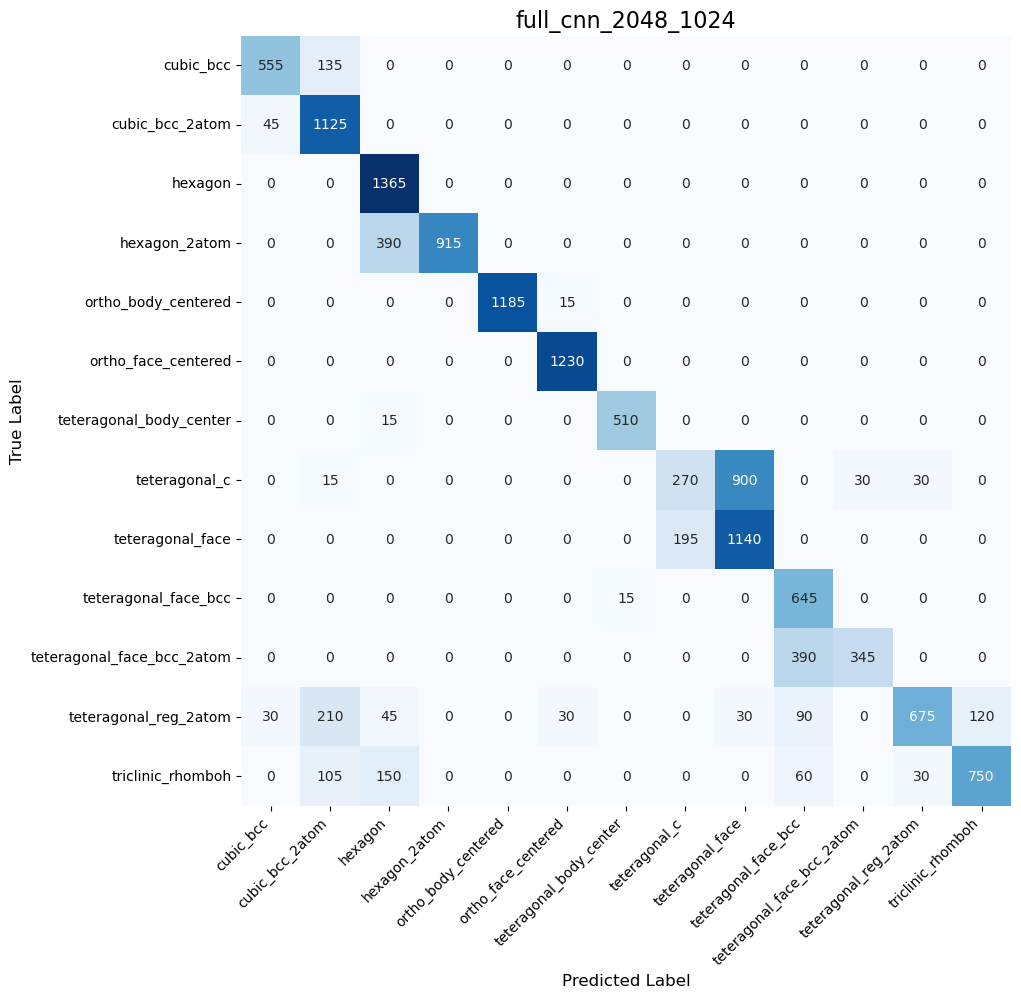

In [20]:
#Plot confusion matrix for test dataset if available, otherwise on validation dataset
# Get the predicted labels for the validation set
predicted_label = np.argmax(model_vgg.predict(valid_ds), axis =-1)

# Get the true labels for the validation set
true_classes = np.concatenate([y for x, y in valid_ds], axis=0)

#labels are one hot encoded, so convert them into the integers for confusion matrix
true_classes = np.argmax(true_classes , axis=-1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes , predicted_label)

# Define the class names
class_names = ds_valid.class_names


def plot_heatmap(y_true, y_pred, class_names, ax, title):
    """ A function to get predict
    ed and true y labels and plot a heatmap (from seaborn) of true prediction """
    cm = confusion_matrix(y_true, y_pred)
    heatmap(
            cm, 
            annot = True, 
            square= True, 
            xticklabels = class_names, 
            yticklabels = class_names,
            fmt  = "d", 
            cmap = plt.cm.Blues,
            cbar = False, 
            ax = ax
            )
    ax.set_title(title, fontsize = 16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right")
    ax.set_ylabel("True Label", fontsize = 12)
    ax.set_xlabel("Predicted Label", fontsize = 12)

fig, ax1 = plt.subplots(1, 1, figsize = (15, 10))
plot_heatmap(true_classes, predicted_label, class_names, ax1, title=title)    
plt.savefig(folder_dest +"/" + title + "_confusion_plot.png", bbox_inches = "tight")

In [21]:
# To just get confusion matrix for the validation dataset

y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in ds_valid:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_vgg.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

print(confusion_matrix(np.argmax(correct_labels, axis = -1), predicted_labels))

[[23  2  0  0  0  0  0  0  9  0  0  0 12]
 [39  0  0  0  0  1  1  0 24  6  0  0  7]
 [13  0 27  0  0 18 10  0  0  0  0  0 23]
 [10  0  0  0  0 21 16  0  0  4  0  0 36]
 [ 0  0  0  0 32 48  0  0  0  0  0  0  0]
 [ 1  0  0  0  0 77  0  0  1  3  0  0  0]
 [ 6  0  0  0  0  0 14  2  2  3  0  1  7]
 [ 1  8  0  2  0 21  1  9 37  1  0  2  1]
 [ 0  7  0  2  0 22  0  9 37  4  0  5  3]
 [ 1  0  0  0  0 15  6  4  0 10  0  2  6]
 [ 6  0  0  0  0 12 10  5  9  0  0  2  5]
 [21  4  2  5  0 10  5  2 12  9  0  2 10]
 [14  1  0  0  0 34  5  0  0  5  0  0 14]]


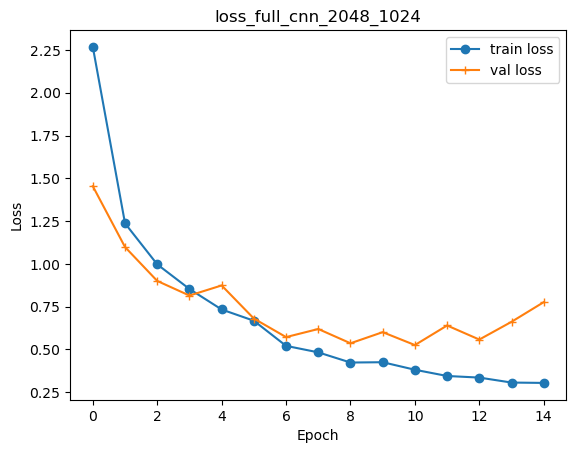

In [22]:
# Plot Loss
history = random_lattice_vgg.history
plt.plot(history["loss"],   label = "train loss", marker = "o")
plt.plot(history["val_loss"], label = "val loss", marker = "+")
plt.legend()
plt.title(f"loss_{title}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig(folder_dest +"/"+ title + "_loss.png", dpi=300, bbox_inches='tight')
plt.show()

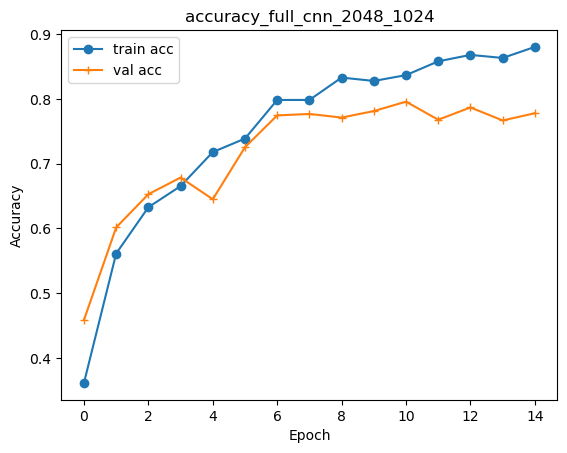

In [23]:
# Plot Accuracy
plt.plot(history["accuracy"],   label = "train acc", marker = "o")
plt.plot(history["val_accuracy"], label = "val acc", marker = "+")
plt.legend()
plt.title(f"accuracy_{title}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.savefig(folder_dest +"/"+ title + "_accuracy.png", dpi=300, bbox_inches='tight')
plt.show()

In [24]:
#Calculate the score of train and valid sets and make a table
score_valid=model_vgg.evaluate(valid_ds, batch_size = batch_size, return_dict=True)
score_train=model_vgg.evaluate(train_ds, batch_size = batch_size, return_dict=True)

score_eval = pd.DataFrame({"score_valid" : score_valid, "score_train": score_train})
score_eval.to_csv(folder_dest + f"score evaluation {title}")
score_eval

1020/1020 [==============================] - 215s 210ms/step - loss: 0.2458 - accuracy: 0.9035


,score_valid,score_train
loss,0.778423,0.245848
accuracy,0.776931,0.903497


## Prediction

real class and the predicted class are both  ortho_face_centered


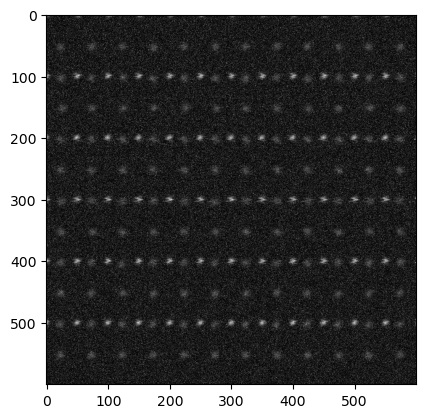

In [156]:
#Let's test model

train_ds_1=ds_train.unbatch()
for image, label in train_ds_1.take(1):
    # Determine the predicted class 
    predicted_class_value = np.argmax(model_vgg.predict(tf.expand_dims(image, 0)), axis = -1)[0]
    predicted_class_name = classes[predicted_class_value]
    #Determine the true class
    true_class= classes[np.argmax(label)]
    if predicted_class_name == true_class:
        print("real class and the predicted class are both ", true_class)
    else:
        print("real class is ", true_class," but predicted class is ", predicted_class_name )
    #print(f"The true class is {true_class} and the predicted class is {predicted_class_name}")
    plt.imshow(image/255.0);